In [1]:
import numpy as np
import nengo

import matplotlib.pyplot as plt
%matplotlib inline

from preprocess import *

dt = 0.001
trange = (0, np.round(2*np.pi, decimals=3))
filename = "processed/out_61_pn_2.npz"

['nnRawExaStride', 'min_maxs', 'nnRawSlowWalk']


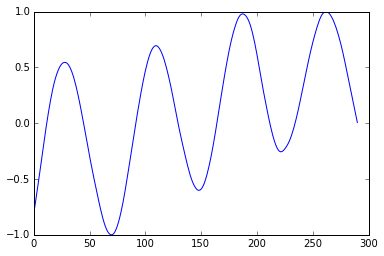

In [2]:
af = np.load(filename)
print(af.keys())
plt.plot(af["nnRawExaStride"][0])

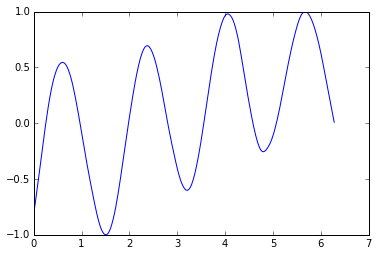

In [3]:
target = get_function_list(1, 2, filename, trange)[0][0]
print(target)
t_val = np.arange(trange[0], trange[1], dt)
plt.plot(t_val, target(t_val))

In [4]:
t_val

array([  0.00000000e+00,   1.00000000e-03,   2.00000000e-03, ...,
         6.28000000e+00,   6.28100000e+00,   6.28200000e+00])

In [32]:
model = nengo.Network()
tau = 0.1
ENS_SEED = 1
ENS_N_NEURONS = 100
#model.config[nengo.Ensemble].neuron_type = nengo.Direct()

with model:
    sig = nengo.Node(lambda t: (np.cos(t), np.sin(t)))
    readout = nengo.Ensemble(n_neurons=ENS_N_NEURONS, dimensions=2, seed=ENS_SEED)
    nengo.Connection(sig, readout, synapse=None)
    p_spikes = nengo.Probe(readout.neurons, synapse=0.01)
    p_readout = nengo.Probe(readout, synapse=0.1)

In [39]:
sim_train = nengo.Simulator(model)
with sim_train:
    print(sim_train.dt)
    sim_train.run(trange[1])

0.001
Simulation finished in 0:00:03.                                                 


In [43]:
print(sim_train.data[p_spikes].shape)
solver = nengo.solvers.LstsqL2(reg=0.02)
decoders, info = solver(sim_train.data[p_spikes], target(sim_train.trange())[:, None])
print(decoders.shape)

(6283, 100)
(100, 1)


6.283
(6283,)
6.283
(6283,)


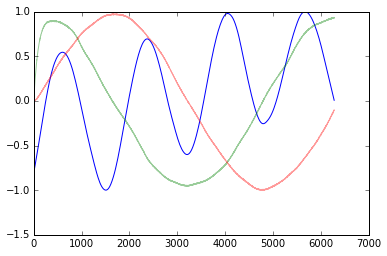

In [44]:
print(sim_train.trange()[-1])
print(sim_train.trange().shape)
print(trange[-1])
print(t_val.shape)
plt.plot(target(sim_train.trange()))
plt.plot(sim_train.data[p_readout], alpha=0.4)

In [45]:
test_model = nengo.Network()
with test_model:
    sig = nengo.Node(lambda t: (np.cos(t), np.sin(t)))

    readout = nengo.Ensemble(n_neurons=ENS_N_NEURONS, dimensions=2, seed=ENS_SEED)
    nengo.Connection(sig, readout, synapse=None)

    output = nengo.Node(size_in=1)
    nengo.Connection(readout.neurons, output, transform=decoders.T)
    
    p_out = nengo.Probe(output, synapse=0.01)

In [46]:
sim_test = nengo.Simulator(test_model)
with sim_test:
    print(sim_test.dt)
    sim_test.run(trange[1]*2)

0.001
Simulation finished in 0:00:04.                                                 


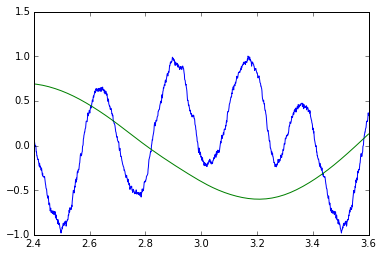

In [37]:
strt = int(2.4/dt)
end = int(3.6/dt)
t_test = sim_test.trange()[strt:end]
plt.plot(t_test, sim_test.data[p_out][strt:end])
plt.plot(t_test, target(t_test))

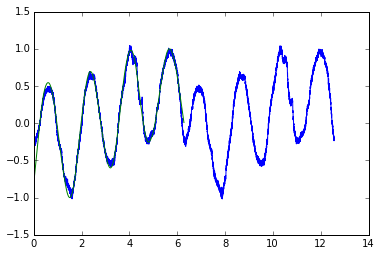

In [48]:
plt.plot(sim_test.trange(), sim_test.data[p_out])
plt.plot(t_val, target(t_val))